# *FORECASTING* CON REDES LSTM - PARTE 1: PREPARACI√ìN DE LOS DATOS

## Contenido

1. [Introducci√≥n]
2. [El set de datos]
3. [El problema a resolver]
4. [Lectura del set de datos]
5. [Procesamiento inicial del dataset]
6. [An√°lisis exploratorio]
7. [Pre-procesamiento]
8. [Conclusi√≥n]

## 1. Lectura del set de datos

In [388]:
import plotly.express as px

In [389]:
#from google.colab import drive
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

# Montar Google Drive
#drive.mount('/gdrive')

# Leer set de datos
ruta = './'
datos = pd.read_csv(ruta+'Ventas_Total2.csv', delimiter=';')
#datos = pd.read_csv(ruta+'Ventas_SENSODYNEBLANQ_2016_2024.csv', delimiter=';')
#datos = pd.read_csv(ruta+'Ventas_XARELTO_2016_2024.csv', delimiter=';')

datos.tail()



Fecha Codigo                        POS  id_item  \
831192  11/4/2024 13:47  PG077  PH GYE SUPERCINES ORELLAN    88275   
831193  11/4/2024 18:12  PG077  PH GYE SUPERCINES ORELLAN    88275   
831194  23/4/2024 13:59  BPP27  FARMACIA BP UIO CLINICA I    88275   
831195  23/5/2024 10:50  BPP27  FARMACIA BP UIO CLINICA I    88275   
831196  18/6/2024 16:04  BPP27  FARMACIA BP UIO CLINICA I    88275   

                     Descripcion_larga  cantidad_unid  cantidad_frac latitud  \
831192  MICARDIS PLUS COMx80/12.5MGx28              0              7    #N/D   
831193  MICARDIS PLUS COMx80/12.5MGx28              0              7    #N/D   
831194  MICARDIS PLUS COMx80/12.5MGx28              2              0    #N/D   
831195  MICARDIS PLUS COMx80/12.5MGx28              1              0    #N/D   
831196  MICARDIS PLUS COMx80/12.5MGx28              0              7    #N/D   

       longitud provincia  
831192     #N/D      #N/D  
831193     #N/D      #N/D  
831194     #N/D      #N/D  
831195     #N/D      #N/D  
831196     #N/D      #N/D

In [390]:
# datos.rename(columns={'cantidad': 'cantidad_frac'}, inplace=True)
# datos.head()
idItem = 90765

## 2. Procesamiento inicial del dataset

In [391]:
# Suponiendo que df es tu DataFrame original y quieres seleccionar solo ciertas columnas
columnas_especificas = ['Fecha', 'id_item', 'cantidad_unid','cantidad_frac']
datos = datos[columnas_especificas]
datos = datos[datos['id_item'] == idItem]


In [392]:
def validar_y_actualizar(fila):
    if  fila["cantidad_unid"] >= 1:
        if (fila['id_item'] == 13887): #JERINGA MEGA INSUL 1MLx29Gx1/2x100
          fila["cantidad_frac"] += 100 * int(fila["cantidad_unid"])
          #datos = datos = datos.rename(columns={'cantidad_unid': 'cantidad_frac'})
          #fila["cantidad_unid"] = 0
        elif fila['id_item'] in {90765, 79680, 27112, 1669, 101609, 13480}: #x'unidad  
          fila["cantidad_frac"] += int(fila["cantidad_unid"])

        elif(fila['id_item'] == 54122): #XARELTO COM-RECx10MGx10
          fila["cantidad_frac"] += 10 * int(fila["cantidad_unid"])
        
        elif(fila['id_item'] == 88275): #MICARDIX
           fila['cantidad_frac'] += 28 * int(fila["cantidad_unid"])  

    return fila


# Aplicar la funci√≥n a cada fila
datos = datos.apply(validar_y_actualizar, axis=1)
datos = datos.drop(columns = ["cantidad_unid"])

### 2.1 Manipulaci√≥n de fechas

In [393]:
# verificar que el tipo de dato es object 'O'
datos["Fecha"].dtype

dtype('O')

In [394]:
# Pasar la columna de Fecha al formato datetime
datos['Fecha'] = pd.to_datetime(datos['Fecha'], format='%d/%m/%Y %H:%M')
# Establecer la hora y el minuto a 0
datos['Fecha'] = datos['Fecha'].apply(lambda dt: dt.replace(hour=0, minute=0, second=0))
datos = datos.groupby(['Fecha', 'id_item'], as_index= False).sum()
# Ordenemos el dataset de forma ascendente seg√∫n "fecha"
datos.sort_index(inplace=False)
datos.set_index('Fecha', inplace= True)
df = datos


In [395]:
df.head()


id_item  cantidad_frac
Fecha                             
2016-01-01    90765             12
2016-01-02    90765             14
2016-01-03    90765             20
2016-01-04    90765             15
2016-01-05    90765             27

## 3. Pre-procesamiento

**Se tiene 6 variables**
- *Fecha*: Fecha de compra del producto
- *codigo*: codigo de la farmacia donde se compro el producto
- *POS*: nombre de la farmacia
- *id_item*: codigo del producto
- *Descripcion_larga*: nombre del producto
- *cantidad_uni*: cantidad de producto comprada


**Tendremos dos tipos de variables al momento de implementar los modelos LSTM:**
- Variable a predecir: la variable a pronosticar (salida del modelo LSTM). En este caso es *cantidad_unid*

- Variables predictoras (o covariables): las variables de entrada al modelo LSTM a partir de las cuales se realizar√° la predicci√≥n.
  - Puede incluir la variable a predecir (*cantidad_unid*)
  - Puede incluir la variable tiempo (columna *Fecha*)


---



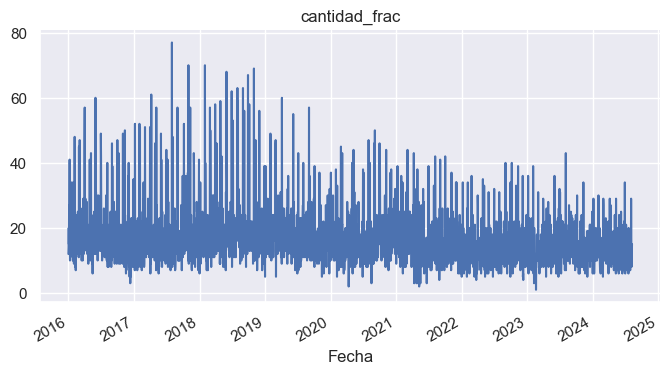

In [396]:
df['cantidad_frac'].plot(kind='line', figsize=(8, 4), title='cantidad_frac')
plt.gca().spines[['top', 'right']].set_visible(False)

**Observaciones:**
Al parecer hay varios outliers, en espec√≠fico el que est√° a mediados del a√±o 2022. Otro punto a considerar es que no se encuentran registros del a√±o 2021 por motivos de pandemia es un a√±o que se presta a valores atipicos.


---



In [397]:
# verficar datos faltantes
print('Cantidad de NaNs:')
for column in df:
    nans = df[column].isna().sum()

    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna id_item: 0
	Columna cantidad_frac: 0


garantizar que la periodicidad de las muestras es exactamente de 1 d√≠a:

In [398]:
# Convertir el √≠ndice a fecha y hora si a√∫n no lo est√°
df.index = pd.to_datetime(df.index)

# Calcular diferencias (en d√≠as) entre cada par de datos consecutivos
df_time_diffs = df.index.to_series().diff().dt.days

# Contar las ocurrencias de cada diferencia
print(df_time_diffs.value_counts())

Fecha
1.0    3125
2.0       8
Name: count, dtype: int64



Por lo tanto vemos que:

- hay 2178 pares de registro con una diferencia de 1 d√≠a.
- hay 4 pares de registro con una diferencia de 2 d√≠as.
- hay 1 par de registros con una diferencia de 368 d√≠as. (la fecha de pandemia)

No hay datos faltantes
Pero debemos mejorar la perioricidad del dataset

### 3.1. Ajuste de la periodicidad del dataset


In [399]:
# Reinterpolar el dataset con una periodicidad de 1 d√≠a
#df2 = df.asfreq(freq='D', method='bfill')
df2 = df.asfreq(freq='D', method='ffill')
#df2 = df.asfreq(freq='D', fill_value=0)

# Y verificar que la totalidad del dataset tiene esta periodicidad
df_time_diffs = df2.index.to_series().diff().dt.days
print(df_time_diffs.value_counts())

Fecha
1.0    3141
Name: count, dtype: int64


In [400]:
# # Funci√≥n para eliminar outliers y reemplazarlos por el valor promedio
# def eliminar_outliers(df, columnas):
#     for columna in columnas:
#         Q1 = df[columna].quantile(0.25)
#         Q3 = df[columna].quantile(0.75)
#         IQR = Q3 - Q1
#         limite_inferior = Q1 - 1.5 * IQR
#         limite_superior = Q3 + 1.5 * IQR

#         # Calcular el promedio sin outliers
#         promedio_sin_outliers = df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)][columna].mean()

#         # Reemplazar los outliers por el promedio
#         df[columna] = df[columna].apply(lambda x: promedio_sin_outliers if (x < limite_inferior or x > limite_superior) else x)

#     return df

# #Seleccionar las columnas que deseas procesar
# columnas_a_procesar = ['cantidad_frac']  # Ajusta seg√∫n tus necesidades

# # Aplicar la funci√≥n
# df2 = eliminar_outliers(df2, columnas_a_procesar)




In [401]:
# Verificar que el dataset resultante no contiene NaNs:
print('Cantidad de NaNs:')
for column in df:
    nans = df2[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna id_item: 0
	Columna cantidad_frac: 0


In [402]:
# Y finalmente verificar las columnas originales y modificadas
for column in df:
  if pd.api.types.is_numeric_dtype(df2[column]):
    # Calcular y imprimir promedios solo para columnas flotantes
    print(f'Promedios original/modificado: {df[column].mean():.2f}/{df2[column].mean():.2f}')


Promedios original/modificado: 90765.00/90765.00
Promedios original/modificado: 16.68/16.69


In [403]:
df = df2

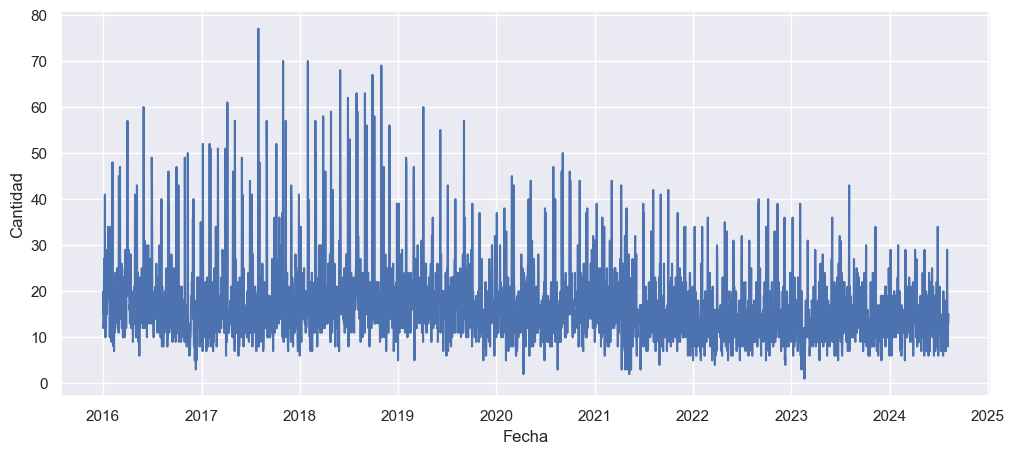

In [404]:
# Importar seaborn
import seaborn as sns
sns.set()

# Extraer la temperatura
temp = df['cantidad_frac']

# Y graficarla
fig, ax = plt.subplots(figsize=(12,5))
ax.set_ylabel('Cantidad')
sns.lineplot(temp, ax=ax);

In [405]:
var = pd.infer_freq(df.index)
print(var)

D


In [406]:

# 0. Par√°metros de la serie de tiempo
N = len(temp) # Cantidad de muestras: [muestras]
muestras_dia = 1# N√∫mero de muestras/d√≠a: [muestras/d√≠a]

# 1. Calcular la magnitud de la Transformada de Fourier derecha
tf = np.abs(np.fft.rfft(temp,N))

# 2. Calcular vector frecuencias (eje horizontal)
# Ahora calculamos las frecuencias en ciclos por d√≠a
frecs = np.fft.rfftfreq(N, d=1./muestras_dia)

# 3. Graficar
# Como tenemos 1 muestra por d√≠a pero la serie dura varios a√±os
# usaremos una escala logar√≠tmica en el eje horizontal
fig = px.line(x=frecs, y=tf, log_x=True)
fig.update_layout(xaxis_title=f'Frecuencia (1/D√≠a)')
fig.show()

In [407]:
frec1 = 318.1674e-6
frec2 = 954.5021e-6
frec3 = 0.2857143


print(f'La frecuencia {frec1} equivale a {1/frec1} d√≠as')
print(f'La frecuencia {frec2} equivale a {1/frec2} d√≠as')
print(f'La frecuencia {frec3} equivale a {1/frec3} d√≠as')

La frecuencia 0.0003181674 equivale a 3142.9995656374604 d√≠as
La frecuencia 0.0009545021 equivale a 1047.6666316396788 d√≠as
La frecuencia 0.2857143 equivale a 3.499999825000009 d√≠as


In [408]:
# Codificar cada combinaci√≥n AAAA-MM-DD HH:MM:SS a su representaci√≥n
# en segundos
tiempo_s = df.index.map(pd.Timestamp.timestamp)
tiempo_s

Index([1451606400.0, 1451692800.0, 1451779200.0, 1451865600.0, 1451952000.0,
       1452038400.0, 1452124800.0, 1452211200.0, 1452297600.0, 1452384000.0,
       ...
       1722211200.0, 1722297600.0, 1722384000.0, 1722470400.0, 1722556800.0,
       1722643200.0, 1722729600.0, 1722816000.0, 1722902400.0, 1722988800.0],
      dtype='float64', name='Fecha', length=3142)

In [409]:
# Por ejemplo, entre dos instantes de tiempo consecutivos
# habr√° exactamente 3.600 segundos = 1 hora!
tiempo_s[2]-tiempo_s[1]

86400.0

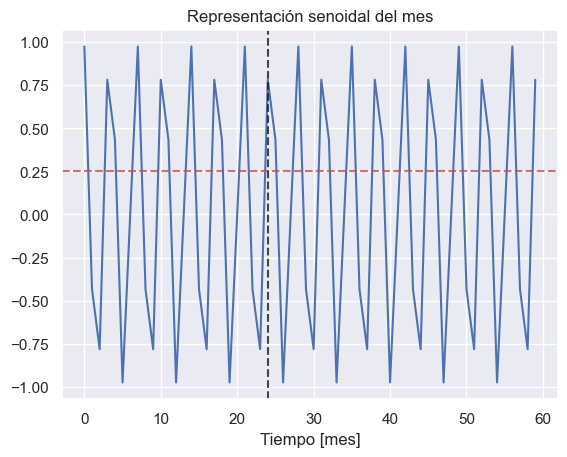

In [410]:
# Definir 1 mes en segundos como 30dias x 24 horas x 60 min x 60 s
#mes = 30*24*60*60

mes = 302400
      

# Representar el d√≠a senoidal y cosenoidalmente
# La frecuencia de la funci√≥n ser√° 1/d√≠a
mes_sin = np.sin(tiempo_s * (2 * np.pi / mes))

# Graficar 5 a√±√≥s  (60 meses)
fig, ax = plt.subplots()
plt.plot(np.array(mes_sin)[:60])
plt.xlabel('Tiempo [mes]')
plt.title('Representaci√≥n senoidal del mes')

# Dibujar l√≠nea horizontal en y = 0.5
ax.axhline(0.25, color='r', linestyle='--', alpha=0.8)

# Dibujar l√≠nea vertical en 24 horas
ax.axvline(24, color='k', linestyle='--', alpha=0.8);

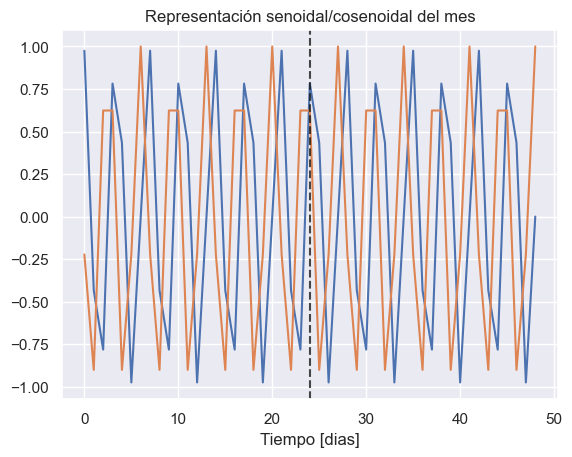

In [411]:
# Representar la hora con senos y cosenos
mes_sin = np.sin(tiempo_s * (2 * np.pi / mes))
mes_cos = np.cos(tiempo_s * (2 * np.pi / mes))

# Graficar 2 d√≠as (48 horas)
fig, ax = plt.subplots()
plt.plot(np.array(mes_sin)[:49])
plt.plot(np.array(mes_cos)[:49])
plt.xlabel('Tiempo [dias]')
plt.title('Representaci√≥n senoidal/cosenoidal del mes')

# Dibujar l√≠nea vertical en 24 horas
ax.axvline(24, color='k', linestyle='--', alpha=0.8);

In [412]:
df['mes_sin'] = np.sin(tiempo_s * (2 * np.pi / mes))
df['mes_cos'] = np.cos(tiempo_s * (2 * np.pi / mes))

In [413]:
# Insertar las columnas al inicio del DataFrame
df.insert(0, 'mes_sin', df.pop('mes_sin'))
df.insert(1, 'mes_cos', df.pop('mes_cos'))


In [414]:
df.drop(columns=["id_item"], inplace=True)

In [415]:
df

mes_sin   mes_cos  cantidad_frac
Fecha                                        
2016-01-01  0.974928 -0.222521             12
2016-01-02 -0.433884 -0.900969             14
2016-01-03 -0.781831  0.623490             20
2016-01-04  0.781831  0.623490             15
2016-01-05  0.433884 -0.900969             27
...              ...       ...            ...
2024-08-03 -0.433884 -0.900969             14
2024-08-04 -0.781831  0.623490              8
2024-08-05  0.781831  0.623490             14
2024-08-06  0.433884 -0.900969             13
2024-08-07 -0.974928 -0.222521             15

[3142 rows x 3 columns]

### En este punto ya contamos con un dataset √≠ntegro (no contiene datos faltantes ni *outliers* y tiene una periodicidad de 1 d√≠a).
---



### 3.2. Partici√≥n del set de entrenamiento y prueba

1. Partici√≥n en train/val/test (80%, 10%, 10%)
2. Generaci√≥n del dataset supervisado: entrada y salida del modelo
3. Escalamiento

A diferencia de otros modelos de Machine Learning, en el caso de series de tiempo **se debe garantizar que se generan las particiones sin mezclar aleatoriamente los datos**.

Recordemos adem√°s que:
- El set de entrenamiento (*train*) se usar√° para encontrar los par√°metros del modelo
- El set de validaci√≥n (*val*) para verificar que no haya *under/over-fitting* del modelo y para ajustar sus hiperpar√°metros
- El set de prueba (*test*) para poner a prueba el mejor modelo encontrado durante el entrenamiento/validaci√≥n

In [416]:
# Funci√≥n para generar las particiones preservando las caracter√≠sticas
# de la serie de tiempo

#tr_size = 0.8 80% para el entrenamiento
#vl_size = 0.1 10% para la validaci√≥n
#ts_size = 0.1 10% para el test



def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir n√∫mero de datos en cada subserie
    N = dataframe.shape[0]
    Ntrain = int(tr_size*N)  # N√∫mero de datos de entrenamiento
    Nval = int(vl_size*N)    # N√∫mero de datos de validaci√≥n
    Ntst = N - Ntrain - Nval # N√∫mero de datos de prueba

    # Realizar partici√≥n
    train = dataframe[0:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test

# Prueba de la funci√≥n
tr, vl, ts = train_val_test_split(df)

print(f'Tama√±o set de entrenamiento: {tr.shape}')
print(f'Tama√±o set de validaci√≥n: {vl.shape}')
print(f'Tama√±o set de prueba: {ts.shape}')

Tama√±o set de entrenamiento: (2513, 3)
Tama√±o set de validaci√≥n: (314, 3)
Tama√±o set de prueba: (315, 3)


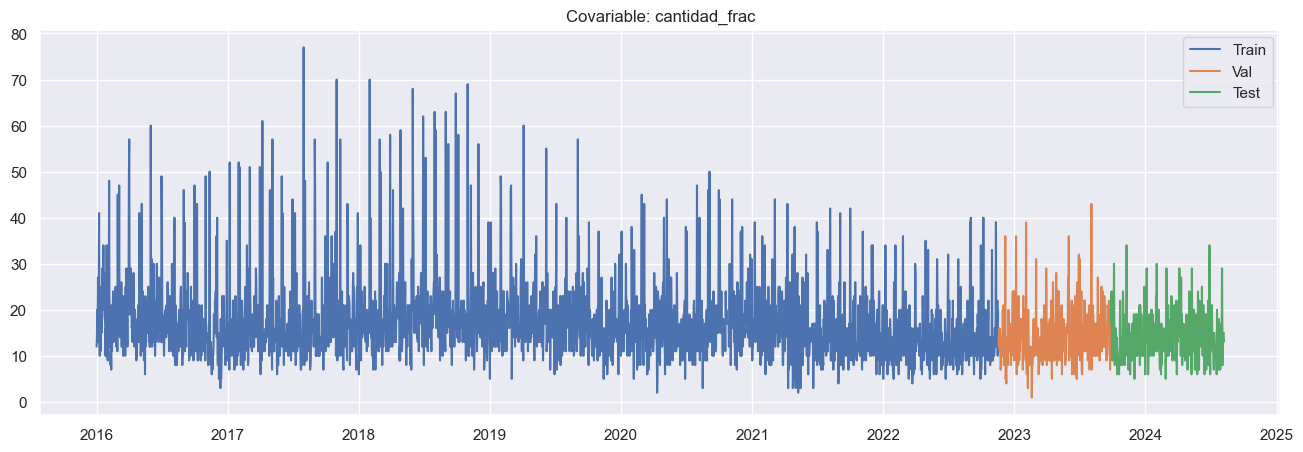

In [417]:
covar = -1 # √çndice de la covariable (columna del dataset) a graficar
col = df.columns[covar]

# Dibujar los sets de entrenamiento/validaci√≥n/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.legend();

### 3.3. Generaci√≥n del dataset supervisado (entrada y salida del modelo)

Debemos ajustar nuestro set de datos de acuerdo a lo especificado en la [documentaci√≥n de las Redes LSTM en TensorFlow/Keras](https://www.tensorflow.)

![](https://drive.google.com/file/d/1ij9pIsJrWVYbwKrZZHY8KtNTlUs1o6AJ/view?usp=sharing)


se tiene 3 dimensiones para la entrada y salida. Como se puede ver en la figura se tiene n cantidad registros(BATCHES) que representan bloques, en la cual cada registro tiene 24 horas como periodo.

Output_lenght: numero de horas que queremos predecir a futuro.

Features(caracteristica) en este caso solo es 1 dado que nuestro modelo es univariado

Output_lenght como es un modelo unistep solo es 1


![image-3.png](attachment:image-3.png)

In [418]:
  def crear_dataset_supervisado(array, input_length, output_length):
      '''Permite crear un dataset con las entradas (X) y salidas (Y)
      requeridas por la Red LSTM.

      Par√°metros:
      - array: arreglo numpy de tama√±o N x features (N: cantidad de datos,
        f: cantidad de features)
      - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
        usados para alimentar el modelo
      - output_length: instantes de tiempo a pronosticar (salida del modelo)
      '''

      # Inicializaci√≥n
      X, Y = [], []    # Listados que contendr√°n los datos de entrada y salida del modelo
      shape = array.shape
      if len(shape)==1: # Si tenemos s√≥lo una serie (univariado)
          fils, cols = array.shape[0], 1
          array = array.reshape(fils,cols)
      else: # Multivariado <-- <--- ¬°esta parte de la funci√≥n se ejecuta en este caso!
          fils, cols = array.shape

      # Generar los arreglos
      for i in range(fils-input_length-output_length):
          X.append(array[i:i+INPUT_LENGTH,0:cols])
          Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
      
      # Convertir listas a arreglos de NumPy
      X = np.array(X)
      Y = np.array(Y)
      
      return X, Y


In [419]:
# Crear los datasets de entrenamiento, prueba y validaci√≥n y verificar sus tama√±os
INPUT_LENGTH = 24    # Hiperpar√°metro
OUTPUT_LENGTH = 4    # Modelo multi-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir informaci√≥n en pantalla
print('Tama√±os entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validaci√≥n - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tama√±os entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (2485, 24, 3), y_tr: (2485, 4, 1)
Set de validaci√≥n - x_vl: (286, 24, 3), y_vl: (286, 4, 1)
Set de prueba - x_ts: (287, 24, 3), y_ts: (287, 4, 1)


### 3.4. Escalamiento
Es requerido para garantizar que todas las caracter√≠sticas se encuentran en el mismo rango de valores, lo que facilita el entrenamiento del modelo y las predicciones:

#### Detecci√≥n de valores extremos usando el m√©todo de la desviaci√≥n est√°ndar
La distribuci√≥n Gaussiana se caracteriza por la media (ùúá) y la desviaci√≥n est√°ndar (ùúé). Conociendo los par√°metros de esta distribuci√≥n podemos establecer una serie de umbrales dentro de los cuales se encontrar√°n distriubidos nuestros datos, as√≠:

En el rango ùúá¬±ùúé tendremos el 68% de los datos
En el rango ùúá¬±2ùúé tendremos el 95% de los datos
En el rango ùúá¬±3ùúé tendremos el 99.7% de los datos


In [420]:
# 
# #Primero vamos a identificar el comportamiento de los outliers mediante una campana gaussiana para observar como est√° la distribuci√≥n
# fig = px.histogram(df, x='cantidad_frac', nbins=100)
# fig.show()

#### STANDARSCALER

In [421]:
from sklearn.preprocessing import StandardScaler

def escalar_dataset(data_input):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})

    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    NFEATS = data_input['x_tr'].shape[2]


    # Generar listado con "scalers" (en este caso, por ser s√≥lo 1 caracter√≠stica
    # se tendr√° s√≥lo 1 escalador)
    scalers = [StandardScaler() for i in range(NFEATS)]  # Remove feature_range
    # Arreglos que contendr√°n los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usar√°n los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs: en este caso debemos garantizar que cada dato de entrada
    # a fit_transform o transform debe ser de tama√±o nsamples x nfeatures
    # (en este caso 24x13)
    print('NFEATS: '+ str(NFEATS))
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0].reshape(-1,1))
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }



    return data_scaled, scalers[0]

#### ROBUSTSCALER

In [422]:
from sklearn.preprocessing import RobustScaler
import numpy as np

def escalar_dataset(data_input):
    '''Escala el dataset usando RobustScaler.

    Entradas:
    data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})

    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (en este caso, por ser s√≥lo 1 caracter√≠stica
    # se tendr√° s√≥lo 1 escalador)
    scalers = [RobustScaler() for i in range(NFEATS)]

    # Arreglos que contendr√°n los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)


    # Escalamiento Xs: en este caso debemos garantizar que cada dato de entrada
    # a fit_transform o transform debe ser de tama√±o nsamples x nfeatures
    # (en este caso 30x1)
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(data_input['x_tr'][:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(data_input['x_vl'][:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(data_input['x_ts'][:,:,i])

    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(data_input['y_tr'][:,:,0].reshape(-1,1))
    y_vl_s[:,:,0] = scalers[-1].transform(data_input['y_vl'][:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(data_input['y_ts'][:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0]


#### MIN MAX SCALER

In [423]:
for i, col in enumerate(tr.columns):
    print(i,col)

0 mes_sin
1 mes_cos
2 cantidad_frac


In [424]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input, col_ref):
    '''Escala solo la columna especificada (col_ref) en el rango de -1 a 1.
    
    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: columna que contiene la variable a predecir (en este caso 'cantidad_frac')
    
    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''
    
    # Determinar el √≠ndice de la columna que contiene la variable a predecir
    col_index = df.columns.get_loc(col_ref)
    
    # Crear el escalador solo para la columna de inter√©s
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # Escalar solo la columna `cantidad_frac` (col_index)
    x_tr_s = data_input['x_tr'].copy()
    x_vl_s = data_input['x_vl'].copy()
    x_ts_s = data_input['x_ts'].copy()
    y_tr_s = data_input['y_tr'].copy()
    y_vl_s = data_input['y_vl'].copy()
    y_ts_s = data_input['y_ts'].copy()

    # Ajustar el escalador en los datos de entrenamiento
    x_tr_s[:, :, col_index] = scaler.fit_transform(x_tr_s[:, :, col_index])
    x_vl_s[:, :, col_index] = scaler.transform(x_vl_s[:, :, col_index])
    x_ts_s[:, :, col_index] = scaler.transform(x_ts_s[:, :, col_index])

    y_tr_s[:, :, 0] = scaler.fit_transform(y_tr_s[:, :, 0])
    y_vl_s[:, :, 0] = scaler.transform(y_vl_s[:, :, 0])
    y_ts_s[:, :, 0] = scaler.transform(y_ts_s[:, :, 0])

    # Aplicar clip para asegurar los valores dentro del rango
    x_tr_s = np.clip(x_tr_s, -1, 1)
    x_vl_s = np.clip(x_vl_s, -1, 1)
    x_ts_s = np.clip(x_ts_s, -1, 1)
    y_tr_s = np.clip(y_tr_s, -1, 1)
    y_vl_s = np.clip(y_vl_s, -1, 1)
    y_ts_s = np.clip(y_ts_s, -1, 1)

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scaler


In [425]:
# Escalamiento del dataset con la funci√≥n anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'cantidad_frac' )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

# Verificaci√≥n
print(f'Min x_tr/x_vl/x_ts sin escalamiento: {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento: {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'\nMin y_tr/y_vl/y_ts sin escalamiento: {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento: {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'\nMax x_tr/x_vl/x_ts sin escalamiento: {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento: {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'\nMax y_tr/y_vl/y_ts sin escalamiento: {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento: {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')

Min x_tr/x_vl/x_ts sin escalamiento: -0.9749279121825313/-0.9749279121824747/-0.9749279121824528
Min x_tr/x_vl/x_ts con escalamiento: -0.9999999999999999/-1.0/-0.9749279121824528

Min y_tr/y_vl/y_ts sin escalamiento: 2.0/1.0/5.0
Min y_tr/y_vl/y_ts con escalamiento: -0.9999999999999999/-1.0/-0.9199999999999999

Max x_tr/x_vl/x_ts sin escalamiento: 77.0/43.0/34.0
Max x_tr/x_vl/x_ts con escalamiento: 1.0/1.0/1.0

Max y_tr/y_vl/y_ts sin escalamiento: 77.0/43.0/34.0
Max y_tr/y_vl/y_ts con escalamiento: 1.0/0.09333333333333349/-0.1466666666666665


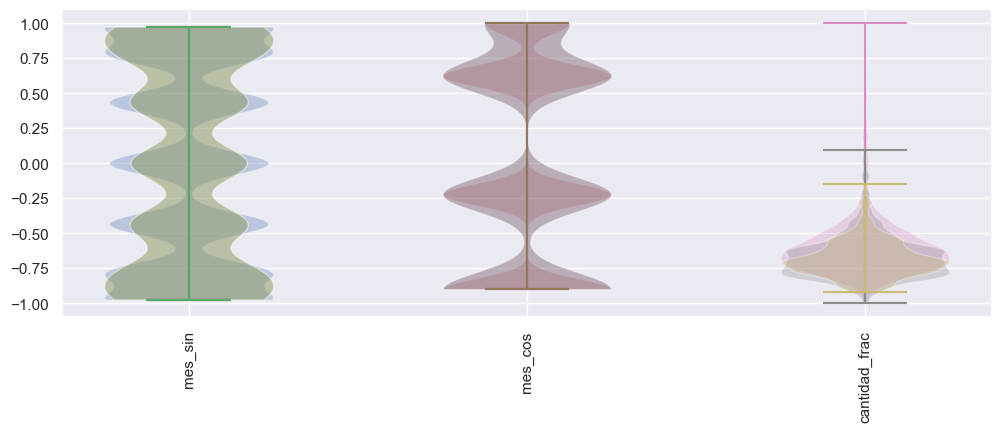

In [426]:
# Y generemos una gr√°fica tipo viol√≠n para ver la distribuci√≥n
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

fig, ax = plt.subplots(figsize=(12,4))
for i in range(3):
    ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
ax.set_xticks(list(range(3)))
ax.set_xticklabels(df.keys(), rotation=90)
ax.autoscale();

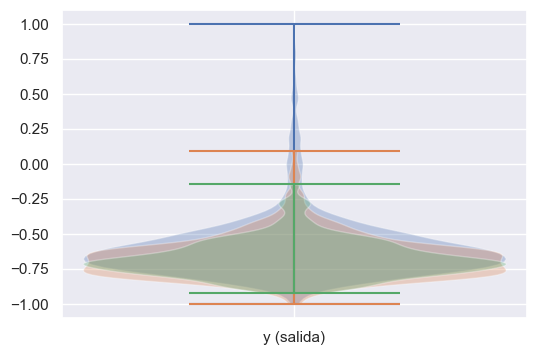

In [427]:
# Y hagamos lo mismo con la variable de salida:
fig, ax = plt.subplots(figsize=(6,4))
ax.violinplot(dataset=y_tr_s.flatten())
ax.violinplot(dataset=y_vl_s.flatten())
ax.violinplot(dataset=y_ts_s.flatten())
ax.set_xticks([1])
ax.set_xticklabels(['y (salida)']);

In [428]:
import pickle

# Escalamiento del dataset
data_s, scaler = escalar_dataset(data_in, 'cantidad_frac')

# Guardar el scaler en un archivo .pkl
with open(f'scaler_{idItem}.pkl', 'wb') as f:
    pickle.dump(scaler, f)

## 4. Creaci√≥n y entrenamieto del Modelo

### 4.1 DROPOUT

In [429]:
# Creaci√≥n del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, Dropout

import tensorflow as tf

# Ajustar par√°metros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 129 # Tama√±o del estado oculto (h) y de la celda de memoria (c)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 24 (d√≠as) x 1 (feature)
DROPOUT_RATE = 0.1  # Tasa de dropout (aj√∫stala seg√∫n tus necesidades)


modelodr = Sequential()
modelodr.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelodr.add(Dropout(DROPOUT_RATE))  # Agregar capa Dropout
modelodr.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresi√≥n)

# P√©rdida: se usar√° el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# P√©rdida: se usar√° el MAE (mean absolute error) para el entrenamiento
# pues permite medir el error absoluto promedio
def mean_absolute_error(y_true, y_pred):
    mae = tf.math.reduce_mean(tf.abs(y_pred - y_true))
    return mae


# Compilaci√≥n
optimizador = RMSprop(learning_rate=5e-5)
modelodr.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error
)

# Mostrar la estructura del modelo
modelodr.summary()


c:\Users\jeanf\miniconda3\envs\streamlit\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_16"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ lstm_16 (LSTM)                  ‚îÇ (None, 129)            ‚îÇ        68,628 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_6 (Dropout)             ‚îÇ (None, 129)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_16 (Dense)                ‚îÇ (None, 4)              ‚îÇ           520 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 69,148 (270.11 KB)

 Trainable params: 69,148 (270.11 KB)

 Non-trainable params: 0 (0.00 B)

In [430]:
# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 50 # Hiperpar√°metro
BATCH_SIZE = 256 # Hiperpar√°metro
historia = modelodr.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/50
10/10 - 2s - 170ms/step - loss: 0.6054 - val_loss: 0.6297
Epoch 2/50
10/10 - 0s - 34ms/step - loss: 0.5819 - val_loss: 0.6056
Epoch 3/50
10/10 - 0s - 35ms/step - loss: 0.5611 - val_loss: 0.5814
Epoch 4/50
10/10 - 0s - 32ms/step - loss: 0.5396 - val_loss: 0.5552
Epoch 5/50
10/10 - 0s - 29ms/step - loss: 0.5163 - val_loss: 0.5260
Epoch 6/50
10/10 - 0s - 38ms/step - loss: 0.4899 - val_loss: 0.4928
Epoch 7/50
10/10 - 0s - 30ms/step - loss: 0.4601 - val_loss: 0.4543
Epoch 8/50
10/10 - 0s - 30ms/step - loss: 0.4265 - val_loss: 0.4093
Epoch 9/50
10/10 - 0s - 31ms/step - loss: 0.3873 - val_loss: 0.3563
Epoch 10/50
10/10 - 0s - 33ms/step - loss: 0.3433 - val_loss: 0.2952
Epoch 11/50
10/10 - 0s - 29ms/step - loss: 0.2976 - val_loss: 0.2312
Epoch 12/50
10/10 - 0s - 29ms/step - loss: 0.2591 - val_loss: 0.1817
Epoch 13/50
10/10 - 0s - 29ms/step - loss: 0.2413 - val_loss: 0.1621
Epoch 14/50
10/10 - 0s - 31ms/step - loss: 0.2362 - val_loss: 0.1579
Epoch 15/50
10/10 - 0s - 29ms/step - loss:

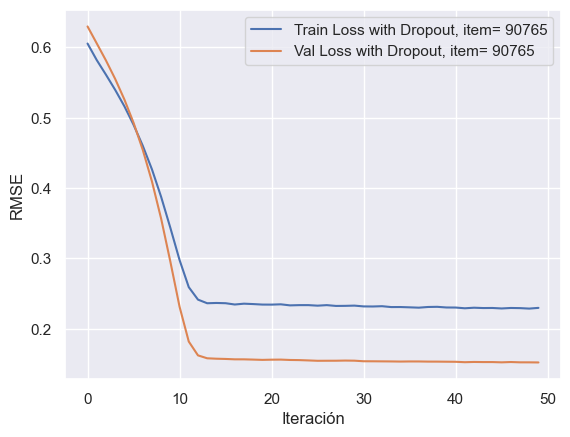

In [431]:
 # Graficar curvas de entrenamiento y validaci√≥n
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label=f'Train Loss with Dropout, item= {idItem}')
plt.plot(historia.history['val_loss'],label=f'Val Loss with Dropout, item= {idItem}')
plt.xlabel('Iteraci√≥n')
plt.ylabel('RMSE')
plt.legend();

### 4.2 SIN DROPOUT

In [432]:
# Creaci√≥n del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

# Ajustar par√°metros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tama√±o del estado oculto (h) y de la celdad de memoria (c) (128)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 24 (horas) x 17 (features)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))

# Y lo √∫nico que cambia con respecto al modelo multivariado + multi-step es
# el tama√±o deldato de salida (4 horas)
modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresi√≥n)

# P√©rdida: se usar√° el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilaci√≥n
optimizador = RMSprop(learning_rate=5e-4) # 5e-5
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 50 # Hiperpar√°metro
BATCH_SIZE = 256 # Hiperpar√°metro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/50
10/10 - 2s - 161ms/step - loss: 0.3977 - val_loss: 0.1831
Epoch 2/50
10/10 - 0s - 33ms/step - loss: 0.2299 - val_loss: 0.1520
Epoch 3/50
10/10 - 0s - 33ms/step - loss: 0.2309 - val_loss: 0.1503
Epoch 4/50
10/10 - 0s - 29ms/step - loss: 0.2266 - val_loss: 0.1531
Epoch 5/50
10/10 - 0s - 28ms/step - loss: 0.2278 - val_loss: 0.1501
Epoch 6/50
10/10 - 0s - 29ms/step - loss: 0.2266 - val_loss: 0.1502
Epoch 7/50
10/10 - 0s - 29ms/step - loss: 0.2261 - val_loss: 0.1498
Epoch 8/50
10/10 - 0s - 28ms/step - loss: 0.2256 - val_loss: 0.1497
Epoch 9/50
10/10 - 0s - 30ms/step - loss: 0.2252 - val_loss: 0.1496
Epoch 10/50
10/10 - 0s - 27ms/step - loss: 0.2249 - val_loss: 0.1495
Epoch 11/50
10/10 - 0s - 29ms/step - loss: 0.2247 - val_loss: 0.1495
Epoch 12/50
10/10 - 0s - 32ms/step - loss: 0.2244 - val_loss: 0.1495
Epoch 13/50
10/10 - 0s - 27ms/step - loss: 0.2243 - val_loss: 0.1495
Epoch 14/50
10/10 - 0s - 29ms/step - loss: 0.2241 - val_loss: 0.1495
Epoch 15/50
10/10 - 0s - 29ms/step - loss:

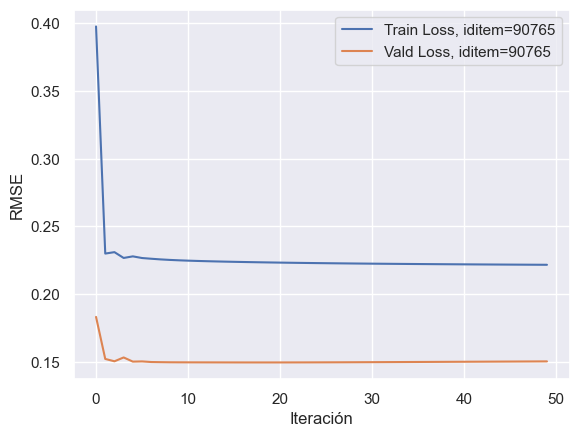

In [433]:
 # Graficar curvas de entrenamiento y validaci√≥n
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label=f'Train Loss, iditem={idItem}')
plt.plot(historia.history['val_loss'],label=f'Vald Loss, iditem={idItem}')
plt.xlabel('Iteraci√≥n')
plt.ylabel('RMSE')
plt.legend();

## GUARDAR MODELO

In [434]:
# Guardar el modelo entrenado
modelo.save(f'modelo_{idItem}.keras')
#modelo.save(f'modelo_{idItem}.keras')

# CARGAR MODELO 1

In [435]:
# def preparar_datos_para_prediccion(df, id_item, input_length, output_length, scaler, modelo):
#     """
#     Predice los valores de los pr√≥ximos d√≠as a partir del √∫ltimo registro en el DataFrame.

#     Args:
#     df (pd.DataFrame): DataFrame que contiene las columnas 'fecha', 'id_item', 'cantidad_frac'.
#     id_item (int/str): El ID del item para el cual se quieren hacer predicciones.
#     input_length (int): El n√∫mero de registros que el modelo necesita como entrada.
#     output_length (int): El n√∫mero de d√≠as a predecir.
#     scaler: El objeto MinMaxScaler que se us√≥ para escalar los datos durante el entrenamiento.
#     modelo: El modelo LSTM cargado para hacer predicciones.

#     Returns:
#     np.array: Predicciones desescaladas para los pr√≥ximos d√≠as.
#     """
#     # Suponiendo que df es tu DataFrame original y quieres seleccionar solo ciertas columnas
#     columnas_especificas = ['Fecha', 'id_item','cantidad_unid', 'cantidad_frac']
#     df = df[columnas_especificas]


#     # Filtrar el DataFrame para el id_item deseado
#     df_item = df[df['id_item'] == id_item].copy()

#     # Ordenar por fecha y tomar los √∫ltimos 'input_length' registros
#     df_item = df_item.sort_values(by='Fecha').tail(input_length)

#     # Asegurarse de que los datos est√©n en el formato correcto (n_samples, input_length, n_features)
#     datos = df_item['cantidad_frac'].values.reshape(-1, 1)

#     # Crear un array con las caracter√≠sticas que espera el scaler (relleno con ceros)
#     datos_expandidos = np.zeros((input_length, scaler.n_features_in_))
#     datos_expandidos[:, 0] = datos[:, 0]  # Copiar los valores en la primera columna

#     # Escalar los datos
#     datos_escalados = scaler.transform(datos_expandidos)

#     # Seleccionar solo la primera columna escalada para la predicci√≥n
#     datos_escalados = datos_escalados[:, 0].reshape(1, input_length, 1)

#     predicciones = []

#     # Iterativamente predecir los pr√≥ximos d√≠as
#     for _ in range(output_length):
#         # Hacer la predicci√≥n
#         prediccion = modelo.predict(datos_escalados)

#         # Crear un array expandido para desescalado
#         prediccion_expandidas = np.zeros((prediccion.shape[0], scaler.n_features_in_))
#         prediccion_expandidas[:, 0] = prediccion[:, 0]

#         # Invertir el escalado de la predicci√≥n
#         prediccion_invertida = scaler.inverse_transform(prediccion_expandidas)

#         # Agregar la primera columna a las predicciones finales
#         predicciones.append(prediccion_invertida[0, 0])

#         # A√±adir la nueva predicci√≥n a los datos para predecir el siguiente d√≠a
#         nueva_entrada = prediccion[0, 0].reshape(1, 1, 1)
#         datos_escalados = np.append(datos_escalados[:, 1:, :], nueva_entrada, axis=1)

#     return np.array(predicciones)


In [436]:

# # Ejemplo de uso:
# id_item = 13887  # Reemplaza con tu id_item espec√≠fico
# input_length = 24  # Este es el valor que usaste para entrenar tu modelo
# output_length = 5  # Los 5 d√≠as que quieres predecir

# # Realizar las predicciones
# predicciones_5_dias = preparar_datos_para_prediccion(df3, id_item, input_length, output_length, scaler_cargado, modelo_cargado)

# print("Predicciones para los pr√≥ximos 5 d√≠as:", predicciones_5_dias)

# CARGAR MODELO 2

In [437]:
from datetime import timedelta
from tensorflow.keras.models import load_model

# Funci√≥n para hacer predicciones
def predecir(x, model, scaler):
    '''Genera la predicci√≥n de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tama√±o: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicci√≥n a la escala original)

    Salida:
    - y_pred: la predicci√≥n en la escala original (tama√±o: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicci√≥n escalada en el rango de -1 a 1
    y_pred_s = model.predict(x, verbose=0)

    # Llevar la predicci√≥n a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

# Cargar el modelo guardado en formato Keras
modelo_cargado = load_model(f'modelo_{idItem}.keras', custom_objects={'root_mean_squared_error': root_mean_squared_error})

# Obtener la √∫ltima fecha del conjunto de datos
ultima_fecha = df.index[-1]

# Generar un rango de fechas futuras
num_predicciones = 4  # N√∫mero de d√≠as a predecir
fechas_futuras = [ultima_fecha + timedelta(days=i) for i in range(1, num_predicciones + 1)]

# Preparar el √∫ltimo segmento del conjunto de datos de entrada desde el conjunto de test
# Este segmento ahora incluye tambi√©n las caracter√≠sticas adicionales (d√≠a, mes, a√±o)
ultimo_segmento = ts[-INPUT_LENGTH:].values
ultimo_segmento = ultimo_segmento.reshape((1, INPUT_LENGTH, ts.shape[1]))  # Ajustado para m√∫ltiples features

# Obtener las predicciones futuras usando el modelo cargado
predicciones_futuras = []
segmento_actual = ultimo_segmento

for _ in range(num_predicciones):
    prediccion = predecir(segmento_actual, modelo_cargado, scaler)
    predicciones_futuras.append(prediccion[0])

    # Actualizar el segmento actual con el nuevo valor predicho
    nuevo_valor = np.array(prediccion[0]).reshape(1, 1, 1)
    # Aqu√≠ se necesitar√≠a tambi√©n actualizar las caracter√≠sticas de d√≠a, mes, a√±o del nuevo valor
    nuevo_segmento = np.array([fechas_futuras[-1].day, fechas_futuras[-1].month, fechas_futuras[-1].year]).reshape(1, 1, 3)
    segmento_actual = np.append(segmento_actual[:, 1:, :], np.hstack((nuevo_valor, nuevo_segmento)), axis=1)

# Crear un DataFrame con las predicciones futuras y sus fechas
resultados_futuros = pd.DataFrame({
    'Fecha': fechas_futuras,
    'Predicci√≥n': predicciones_futuras
})

# Visualizar las predicciones
print(resultados_futuros)

# Si est√°s usando Streamlit, podr√≠as mostrarlo as√≠:
# st.write(resultados_futuros)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 1 and the array at index 1 has size 3

In [ ]:
# from tensorflow.keras.models import load_model
# from datetime import timedelta
# import pandas as pd
# import numpy as np

# def predecir_con_modelo(df, modelo, scaler, input_length, num_predicciones, id_item):
#     """
#     Transforma un DataFrame y genera predicciones futuras utilizando un modelo LSTM cargado.

#     Args:
#     df (pd.DataFrame): DataFrame que contiene las columnas 'fecha', 'id_item', 'cantidad_frac'.
#     modelo: Modelo LSTM cargado desde un archivo .keras.
#     scaler: Objeto MinMaxScaler utilizado para escalar los datos.
#     input_length (int): N√∫mero de registros que el modelo necesita como entrada.
#     num_predicciones (int): N√∫mero de d√≠as a predecir.
#     id_item (int/str): El ID del item para el cual se quieren hacer predicciones.

#     Returns:
#     pd.DataFrame: DataFrame con las fechas futuras y sus correspondientes predicciones.
#     """

#     # Filtrar el DataFrame para el id_item deseado
#     df_item = df[df['id_item'] == id_item].copy()

#     # Obtener la √∫ltima fecha del conjunto de datos
#     ultima_fecha = df_item['Fecha'].max()

#     # Aseg√∫rate de que 'ultima_fecha' sea un objeto datetime
#     if isinstance(ultima_fecha, str):
#         # Si es una cadena, convi√©rtela a datetime
#         # (Asumiendo que el formato de fecha es 'YYYY-MM-DD')
#         ultima_fecha = pd.to_datetime(ultima_fecha)

#     # Generar un rango de fechas futuras
#     fechas_futuras = [ultima_fecha + timedelta(days=i) for i in range(1, num_predicciones + 1)]


#     # Preparar el √∫ltimo segmento del conjunto de datos de entrada
#     ultimo_segmento = df_item['cantidad_frac'].values[-input_length:]
#     ultimo_segmento = ultimo_segmento.reshape((1, input_length, 1))

#     # Escalar el √∫ltimo segmento
#     ultimo_segmento_escalado = np.zeros((input_length, scaler.n_features_in_))
#     ultimo_segmento_escalado[:, 0] = ultimo_segmento[:, 0, 0]
#     ultimo_segmento_escalado = scaler.transform(ultimo_segmento_escalado)
#     segmento_actual = ultimo_segmento_escalado[:, 0].reshape(1, input_length, 1)

#     # Obtener las predicciones futuras usando el modelo cargado
#     predicciones_futuras = []

#     for _ in range(num_predicciones):
#         prediccion = modelo.predict(segmento_actual, verbose=0)

#         # Desescalar la predicci√≥n
#         prediccion_expandidas = np.zeros((prediccion.shape[0], scaler.n_features_in_))
#         prediccion_expandidas[:, 0] = prediccion[:, 0]
#         prediccion_invertida = scaler.inverse_transform(prediccion_expandidas)

#         # Agregar la primera columna a las predicciones finales
#         predicciones_futuras.append(prediccion_invertida[0, 0])

#         # Actualizar el segmento actual
#         nuevo_valor = prediccion[0, 0].reshape(1, 1, 1)
#         segmento_actual = np.append(segmento_actual[:, 1:, :], nuevo_valor, axis=1)

#     # Crear un DataFrame con las predicciones futuras y sus fechas
#     resultados_futuros = pd.DataFrame({
#         'Fecha': fechas_futuras,
#         'Predicci√≥n': predicciones_futuras
#     })

#     return resultados_futuros

# # Ejemplo de uso:
# #df = pd.read_csv('tu_archivo.csv')  # Reemplaza con tu archivo de datos
# input_length = 24  # Este es el valor que usaste para entrenar tu modelo
# num_predicciones = 4  # N√∫mero de d√≠as a predecir
# id_item =13887  # Reemplaza con tu id_item espec√≠fico

# # Cargar el modelo guardado en formato Keras
# modelo_cargado = load_model('modelo_ventas_insulina.keras', custom_objects={'root_mean_squared_error': root_mean_squared_error})

# # Generar las predicciones usando la funci√≥n
# resultados_futuros = predecir_con_modelo(df3, modelo_cargado, scaler, input_length, num_predicciones, id_item)

print(resultados_futuros)


       Fecha  Predicci√≥n
0 2024-08-09  336.840668
1 2024-08-10  328.040131
2 2024-08-11  335.017212
3 2024-08-12  334.722198


In [ ]:
# print("N√∫mero de dimensiones:", resultados_futuros.ndim)
# print("Forma del arreglo:", resultados_futuros.shape)
# print("N√∫mero total de elementos:", resultados_futuros.size)

# DESEMPE√ëO DEL MODELO

In [439]:
# C√°lculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print(f'Comparativo desempe√±os {idItem}:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempe√±os 90765:
  RMSE train:	 0.216
  RMSE val:	 0.150
  RMSE test:	 0.136


Los desempe√±os son comparables lo cual quiere decir que el modelo generaliza bastante bien.

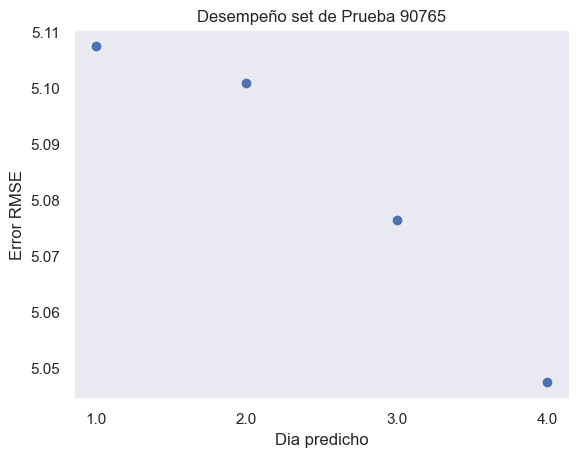

In [444]:
# 1. Generar las predicciones sobre el set de prueba
y_ts_pred_s = modelodr.predict(x_ts_s, verbose=0)

# 2. Realizar la transformaci√≥n inversa de las predicciones para llevar sus
# valores a la escala original
y_ts_pred = scaler.inverse_transform(y_ts_pred_s)

# 3. Calcular RMSE para cada instante de tiempo predicho
diff_cuad = np.square((y_ts.squeeze())-y_ts_pred) # BATCHESx4
proms = np.mean(diff_cuad, axis=0) # 1x4
rmse = np.sqrt(proms) # 1x4

# Graficar rmse para cada timestep
t = np.linspace(1,4,4)

fig, ax = plt.subplots()
ax.scatter(t,rmse)
ax.set_xlabel('Dia predicho')
ax.set_ylabel('Error RMSE')
ax.set_title(f'Desempe√±o set de Prueba {idItem}')
plt.xticks(ticks=t, labels=t)
plt.grid();

In [445]:
def predecir(x, model, scaler):
    '''Genera la predicci√≥n de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tama√±o: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicci√≥n a la escala original)

    Salida:
    - y_pred: la predicci√≥n en la escala original (tama√±o: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicci√≥n escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicci√≥n a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [446]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelodr, scaler)

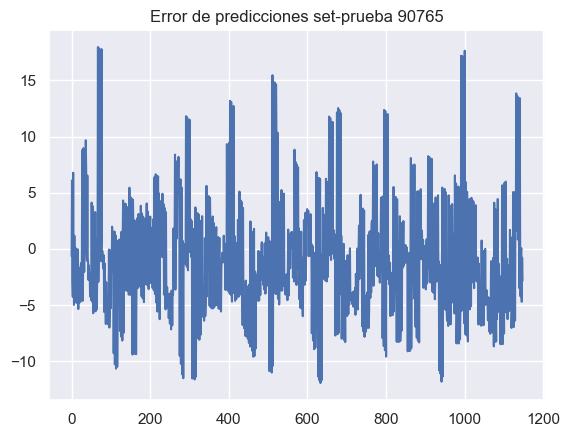

In [447]:
N = len(y_ts_pred)    # N√∫mero de predicciones
ndato = np.linspace(1,N,N)

# C√°lculo de errores simples
errores = (y_ts.flatten()-y_ts_pred)
plt.title(f'Error de predicciones set-prueba {idItem}')
plt.plot(errores);

In [448]:
 from datetime import timedelta

# Obtener la √∫ltima fecha del conjunto de datos
ultima_fecha = df.index[-1]

# Generar un rango de fechas futuras
num_predicciones = 4  # N√∫mero de d√≠as a predecir
fechas_futuras = [ultima_fecha + timedelta(days=i) for i in range(1, num_predicciones + 1)]

# Preparar el √∫ltimo segmento del conjunto de datos de entrada desde el conjunto de test
ultimo_segmento = ts[-INPUT_LENGTH:].values
ultimo_segmento = ultimo_segmento.reshape((1, INPUT_LENGTH, 3))

# Obtener las predicciones futuras
predicciones_futuras = []
segmento_actual = ultimo_segmento.copy()  # Create a copy to avoid modifying the original

for _ in range(num_predicciones):
    prediccion = predecir(segmento_actual, modelo, scaler)
    predicciones_futuras.append(prediccion[0])

    # Actualizar el segmento actual - Instead of appending and slicing,
    # shift the values and insert the new prediction at the end
    segmento_actual = np.roll(segmento_actual, -1, axis=1)
    segmento_actual[0,-1,0] = prediccion[0]

# Crear un DataFrame con las predicciones futuras y sus fechas
resultados_futuros = pd.DataFrame({
    'Fecha': fechas_futuras,
    'Predicci√≥n': predicciones_futuras
})

resultados_futuros.set_index('Fecha', inplace=True)


In [449]:
print(resultados_futuros)

            Predicci√≥n
Fecha                 
2024-08-08   77.061119
2024-08-09   61.960026
2024-08-10   33.560558
2024-08-11   19.071920
